## High-level settings, imports

In [1]:
import os
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torchvision.datasets import MNIST, FashionMNIST

n_epochs = 10
batch_size = 64
image_shape = (1, 28, 28)
output_classes = 10
device = 'cuda'
results_dir = os.path.join('.', 'results', 'mnist_antigan_features__2022_9_21_13_52_2', 'trial_0')
digitize_bits = None
dataset = MNIST
dataset_path = os.path.join('.', 'saved_datasets', 'MNIST')

## Initialize discriminator model

## Initialize datasets and dataloaders

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose

training_dataset = dataset(
    root=dataset_path,
    train=True,
    download=False,
    transform=Compose((ToTensor(), Normalize(mean=(0.5,), std=(0.5,)))))
testing_dataset = dataset(
    root=dataset_path,
    train=False,
    download=False,
    transform=Compose((ToTensor(), Normalize(mean=(0.5,), std=(0.5,)))))
training_dataloader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
testing_dataloader = DataLoader(testing_dataset, shuffle=False, batch_size=batch_size)

## Load trained generator

In [3]:
from models.lenet_gan import SimpleGen

gen = SimpleGen(
    latent_dims=100,
    label_dims=10,
    output_shape=(batch_size, *image_shape),
    output_classes=10)
gen.load_state_dict(torch.load(os.path.join(results_dir, 'trained_generator')))
gen.eval()

print(gen)

SimpleGen(
  (feature_encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
  )
  (label_encoder): Sequential(
    (0): Embedding(10, 10)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=9, bias=True)
  )
  (latent_encoder): Sequential(
    (0): Linear(in_features=100, out_features=216, bias=True)
    (1): ReLU()
    (2): Linear(in_features=216, out_features=108, bias=True)
  )
  (feature_decoder): Sequential(
    (0): ConvTranspose2d(45, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 

## Define training functions

In [4]:
from models.lenet5 import LeNet5

def digitize_image(image):
    image = 255*(.5*image+.5)
    image = image.to(torch.uint8)
    image = image.to(torch.float32)
    image = 2*(image/255)-1
    return image

def get_protected_images(images, labels, override_device=None):
    if override_device is not None:
        latent = torch.randn(batch_size, 100, device=override_device)
        masks = gen.to(override_device)(latent, labels, images)
    else:
        latent = torch.randn(batch_size, 100, device=device)
        masks = gen.to(device)(latent, labels, images)
    protected_images = torch.tanh(images + nn.functional.hardtanh(masks))
    protected_images = digitize_image(protected_images)
    return protected_images

def get_noisy_images(images, *args, override_device=None):
    if override_device is not None:
        noise = 2*torch.rand(images.shape, device=override_device)-1
    else:
        noise = 2*torch.rand(images.shape, device=device)-1
    noisy_images = torch.tanh(images + noise)
    noisy_images = digitize_image(noisy_images)
    return noisy_images

def process_batch(batch, process_image_fn=None, override_device=None):
    images, labels = batch
    images = images.to(override_device if override_device is not None else device)
    labels = labels.to(override_device if override_device is not None else device)
    if process_image_fn is not None:
        images = process_image_fn(images, labels, override_device=override_device)
    return images, labels

def train_step(disc, loss_fn, optimizer, batch, process_image_fn=None):
    images, labels = process_batch(batch, process_image_fn)
    logits = disc(images)
    loss = loss_fn(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

@torch.no_grad()
def eval_step(disc, loss_fn, batch, process_image_fn=None, override_device=None):
    images, labels = process_batch(batch, process_image_fn, override_device=override_device)
    logits = disc(images)
    loss = loss_fn(logits, labels).cpu().numpy()
    predictions = np.argmax(logits.cpu().numpy(), axis=-1)
    acc = np.mean(np.equal(predictions, labels.cpu().numpy()))
    return loss, acc

@torch.no_grad()
def get_confusion_matrix(disc, batch, process_image_fn=None, override_device=None):
    images, labels = process_batch(batch, process_image_fn=process_image_fn, override_device=override_device)
    logits = disc(images)
    predictions = np.argmax(logits.cpu().numpy(), axis=-1)
    confusion_matrix = np.zeros((10, 10))
    for label, prediction in zip(labels.cpu().numpy(), predictions):
        confusion_matrix[label][prediction] += 1./np.count_nonzero(labels==label)
    confusion_matrix *= (10/labels.size(0))
    return confusion_matrix

def get_confusion_matrix_epoch(disc, dataloader, process_image_fn=None, override_device=None):
    confusion_matrices = []
    for batch in dataloader:
        confusion_matrix = get_confusion_matrix(disc, batch, process_image_fn=process_image_fn, override_device=override_device)
        confusion_matrices.append(confusion_matrix)
    averaged_confusion_matrix = np.mean(confusion_matrices, axis=0)
    return averaged_confusion_matrix

def train_epoch(disc, loss_fn, optimizer, dataloader, process_image_fn=None):
    for batch in dataloader:
        train_step(disc, loss_fn, optimizer, batch, process_image_fn=process_image_fn)

def eval_epoch(disc, loss_fn, dataloader, process_image_fn=None, override_device=None):
    losses, accs = [], []
    for batch in dataloader:
        loss, acc = eval_step(disc, loss_fn, batch, process_image_fn=process_image_fn, override_device=override_device)
        losses.append(loss)
        accs.append(acc)
    return np.mean(losses), np.mean(accs)

def train_disc(process_image_fn=None):
    disc = LeNet5(
        input_shape=(batch_size, *image_shape),
        output_classes=10).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(disc.parameters())
    
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    progress_bar = tqdm(total=3*n_epochs+2)
    def eval_performance():
        nonlocal train_losses, train_accs, test_losses, test_accs
        train_loss, train_acc = eval_epoch(disc, loss_fn, training_dataloader, process_image_fn=process_image_fn)
        progress_bar.update(1)
        test_loss, test_acc = eval_epoch(disc, loss_fn, testing_dataloader, process_image_fn=process_image_fn)
        progress_bar.update(1)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
    eval_performance()
    for epoch in range(n_epochs):
        train_epoch(disc, loss_fn, optimizer, training_dataloader, process_image_fn=process_image_fn)
        progress_bar.update(1)
        eval_performance()
    return disc, (np.array(train_losses), np.array(train_accs), np.array(test_losses), np.array(test_accs))

def display_disc_performance(train_losses, train_accs, test_losses, test_accs, axes=None, color='blue', get_label=lambda s: s):
    if axes is None:
        (fig, axes) = plt.subplots(1, 2, figsize=(8, 4))
    #axes[0].plot(train_losses, '--', color=color, label=get_label('train'))
    axes[0].plot(test_losses, '-', color=color, label=get_label(''))
    #axes[1].plot(1-train_accs, '--', color=color, label=get_label('train'))
    axes[1].plot(1-test_accs, '-', color=color, label=get_label(''))

def display_images(process_image_fn=None, axes=None):
    batch = next(iter(testing_dataloader))
    images, labels = batch
    if process_image_fn is not None:
        images = process_image_fn(images, labels, override_device='cpu')
    images_to_show = {}
    for idx in range(10):
        for label, image in zip(labels, images):
            if label == idx:
                images_to_show[idx] = image
    if axes is None:
        fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for ax, (label, image) in zip(axes.flatten(), images_to_show.items()):
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)), cmap='binary', aspect='equal', interpolation='none')

def display_confusion_matrix(confusion_matrix, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(confusion_matrix, cmap='binary', aspect='equal', interpolation='none')

## Evaluate performance of the generators

In [5]:
clean_disc, clean_res = train_disc()
noisy_disc, noisy_res = train_disc(get_noisy_images)
masked_disc, masked_res = train_disc(get_protected_images)
clean_disc = clean_disc.to('cpu')
noisy_disc = noisy_disc.to('cpu')
masked_disc = masked_disc.to('cpu')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [03:08<00:00,  5.90s/it]


## Display training curves with different types of protection

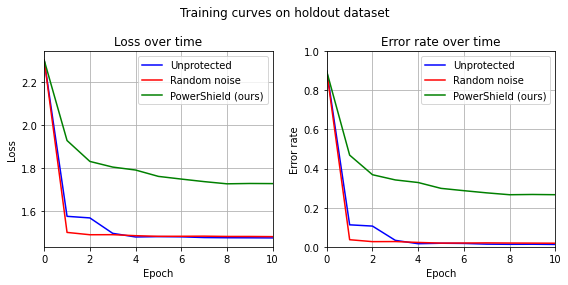

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
display_disc_performance(*clean_res, axes=axes, color='blue', get_label=lambda s: 'Unprotected')
display_disc_performance(*noisy_res, axes=axes, color='red', get_label=lambda s: 'Random noise')
display_disc_performance(*masked_res, axes=axes, color='green', get_label=lambda s: 'PowerShield (ours)')
axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].set_ylabel('Error rate')
axes[0].set_title('Loss over time')
axes[1].set_title('Error rate over time')
axes[0].legend()
axes[1].legend()
axes[0].grid(True)
axes[1].grid(True)
axes[0].set_xlim(0, 10)
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 1)
fig.suptitle('Training curves on holdout dataset')
plt.tight_layout()
fig.patch.set_facecolor('white')
fig.savefig(os.path.join('.', 'mnist_training_curves.png'))

## Displaying images with different types of protection

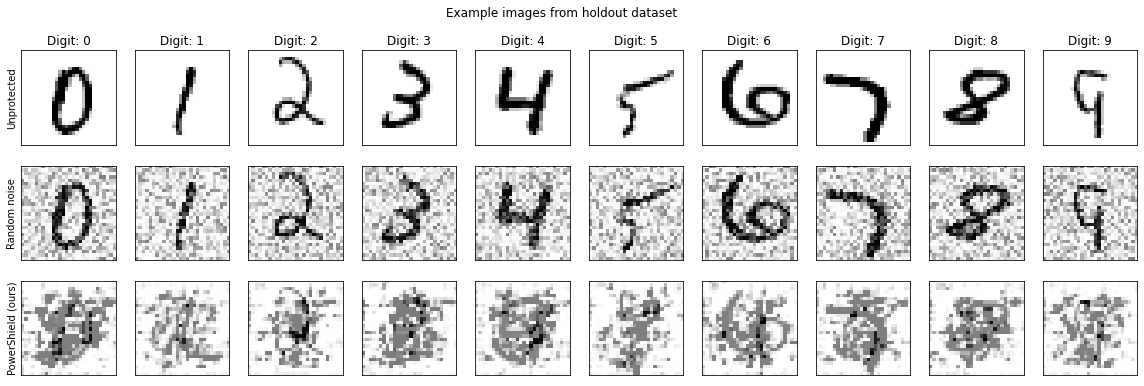

In [11]:
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
display_images(axes=axes[0])
display_images(get_noisy_images, axes=axes[1])
display_images(get_protected_images, axes=axes[2])
axes[0][0].set_ylabel('Unprotected')
axes[1][0].set_ylabel('Random noise')
axes[2][0].set_ylabel('PowerShield (ours)')
for idx in range(10):
    axes[0][idx].set_title('Digit: {}'.format(idx))
fig.suptitle('Example images from holdout dataset')
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
fig.patch.set_facecolor('white')
fig.savefig(os.path.join('.', 'mnist_sampled_images.png'))

## Display confusion matrices with different types of protection

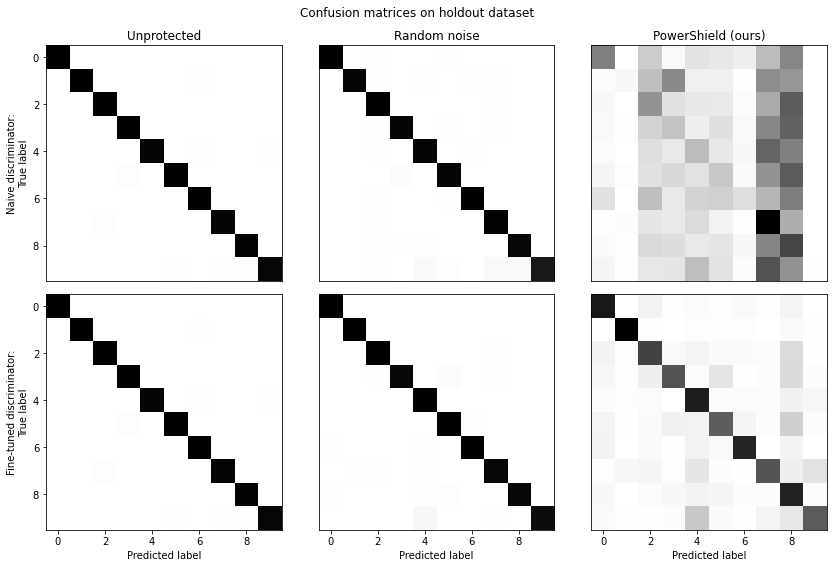

In [12]:
clean_clean_matrix = get_confusion_matrix_epoch(clean_disc, testing_dataloader, process_image_fn=None, override_device='cpu')
clean_noisy_matrix = get_confusion_matrix_epoch(clean_disc, testing_dataloader, process_image_fn=get_noisy_images, override_device='cpu')
clean_masked_matrix = get_confusion_matrix_epoch(clean_disc, testing_dataloader, process_image_fn=get_protected_images, override_device='cpu')
noisy_noisy_matrix = get_confusion_matrix_epoch(noisy_disc, testing_dataloader, process_image_fn=get_noisy_images, override_device='cpu')
masked_masked_matrix = get_confusion_matrix_epoch(masked_disc, testing_dataloader, process_image_fn=get_protected_images, override_device='cpu')

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
display_confusion_matrix(clean_clean_matrix, axes[0][0])
display_confusion_matrix(clean_noisy_matrix, axes[0][1])
display_confusion_matrix(clean_masked_matrix, axes[0][2])
display_confusion_matrix(clean_clean_matrix, axes[1][0])
display_confusion_matrix(noisy_noisy_matrix, axes[1][1])
display_confusion_matrix(masked_masked_matrix, axes[1][2])

for ax in axes[0]:
    ax.set_xticks([])
for ax in axes[:, 1:].flatten():
    ax.set_yticks([])
axes[0][0].set_ylabel('Naive discriminator:\nTrue label')
axes[1][0].set_ylabel('Fine-tuned discriminator:\nTrue label')
for ax in axes[1, :].flatten():
    ax.set_xlabel('Predicted label')
axes[0][0].set_title('Unprotected')
axes[0][1].set_title('Random noise')
axes[0][2].set_title('PowerShield (ours)')
fig.suptitle('Confusion matrices on holdout dataset')
fig.patch.set_facecolor('white')
plt.tight_layout()
fig.savefig(os.path.join('.', 'mnist_confusion_matrices.png'))

## Discriminator error rate after 10 epochs with different types of protection

In [13]:
_, clean_clean_acc = eval_epoch(clean_disc, nn.CrossEntropyLoss(), testing_dataloader, None, 'cpu')
_, clean_noisy_acc = eval_epoch(clean_disc, nn.CrossEntropyLoss(), testing_dataloader, get_noisy_images, 'cpu')
_, clean_masked_acc = eval_epoch(clean_disc, nn.CrossEntropyLoss(), testing_dataloader, get_protected_images, 'cpu')
_, noisy_noisy_acc = eval_epoch(noisy_disc, nn.CrossEntropyLoss(), testing_dataloader, get_noisy_images, 'cpu')
_, masked_masked_acc = eval_epoch(masked_disc, nn.CrossEntropyLoss(), testing_dataloader, get_protected_images, 'cpu')

print('Naive/unprotected:', 1-clean_clean_acc)
print('Naive/random noise:', 1-clean_noisy_acc)
print('Naive/masked:', 1-clean_masked_acc)
print('Fine-tuned/random noise:', 1-noisy_noisy_acc)
print('Fine-tuned/masked:', 1-masked_masked_acc)

Naive/unprotected: 0.012042197452229342
Naive/random noise: 0.03164808917197448
Naive/masked: 0.7985668789808917
Fine-tuned/random noise: 0.017714968152866217
Fine-tuned/masked: 0.2704020700636943
